In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

# deepOF model stability

Given a dataset and a set of trained models, this notebook allows the user to 

* Group all weights according to their parameters
* Load the corresponding models
* Compute cluster assignment for a series of data points
* Compute and visualize the Adjusted Rand Index for each group

In [3]:
import os

os.chdir(os.path.dirname("../"))

In [4]:
import deepof.data
import deepof.utils
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from itertools import combinations
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import adjusted_rand_score

### 1. Define and run project

In [5]:
path = os.path.join("..", "..", "Desktop", "deepof-data", "deepof_single_topview")
trained_network = os.path.join("..", "..", "Desktop", "deepof_trained_weights_280521", "var_overlap_loss")
exclude_bodyparts = tuple([""])
window_size = 24

In [6]:
%%time
proj = deepof.data.project(
    path=path, smooth_alpha=0.999, exclude_bodyparts=exclude_bodyparts, arena_dims=[380],
)

CPU times: user 43.9 s, sys: 2.86 s, total: 46.8 s
Wall time: 39.1 s


In [7]:
%%time
proj = proj.run(verbose=True)
print(proj)

Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...
Computing distances...
Computing angles...
Done!
deepof analysis of 166 videos
CPU times: user 12min 34s, sys: 24.4 s, total: 12min 58s
Wall time: 3min 12s


In [8]:
coords = proj.get_coords(center="Center", align="Spine_1", align_inplace=True)
data = coords.preprocess(test_videos=0, window_step=24, window_size=window_size, shuffle=False)[
    0
]

In [9]:
rand_idx = np.random.choice(range(data.shape[0]), 10000, replace=False)
data = data[rand_idx]

### 2. Load and group model weights

In [10]:
# Group based on training instance length
trained_weights = [os.path.join(trained_network, i) for i in os.listdir(trained_network) if i.endswith("h5")]
trained_weights_dict = {}
for tw in trained_weights:
    added = False
    warmup_mode = re.findall("_warmup_mode=(\w*)_", tw)[0]
    length = re.findall("loss_warmup=(\d*)_", tw)[0]
    rid = "{}_{}".format(warmup_mode, length)
    for key in trained_weights_dict.keys():
        if rid == key:
            trained_weights_dict[key].append(tw)
            added = True
    if not added:
        trained_weights_dict[rid] = [tw]

### 3. Load models and predict clusters for sampled data

In [16]:
groupings_dict = {}

In [17]:
def load_model_and_get_groupings(data, weights):

    # Set model parameters
    encoding = int(re.findall("encoding=(\d+)_", weights)[0])
    k = int(re.findall("k=(\d+)_", weights)[0])
    loss = re.findall("loss=(.+?)_", weights)[0]
    NextSeqPred = float(re.findall("NextSeqPred=(.+?)_", weights)[0])
    PhenoPred = float(re.findall("PhenoPred=(.+?)_", weights)[0])
    RuleBasedPred = float(re.findall("RuleBasedPred=(.+?)_", weights)[0])

    (
        encode_to_vector,
        decoder,
        grouper,
        gmvaep,
        prior,
        posterior,
    ) = deepof.models.SEQ_2_SEQ_GMVAE(
        loss=loss,
        number_of_components=k,
        compile_model=True,
        encoding=encoding,
        next_sequence_prediction=NextSeqPred,
        phenotype_prediction=PhenoPred,
        rule_based_prediction=RuleBasedPred,
    ).build(
        data.shape
    )

    gmvaep.load_weights(os.path.join(weights))
    groups = grouper.predict(data)
    return groups

In [18]:
for k,v in trained_weights_dict.items():
    print(k)
    for tw in tqdm(v):
        if "NextSeqPred=0.15" in tw and "PhenoPred=0.0" in tw and "RuleBasedPred=0.0" in tw:
            try:
                groupings = load_model_and_get_groupings(data, tw)
                try:
                    groupings_dict[k].append(groupings)
                except KeyError:
                    groupings_dict[k] = [groupings]
            except ValueError:
                continue

linear_25



linear_5



sigmoid_25



linear_20



linear_15



sigmoid_5



sigmoid_10



linear_10



sigmoid_20



sigmoid_15


### 4. Obtain ARI score and plot

In [19]:
hard_groups_dict = {
    k: np.concatenate([np.argmax(i, axis=1)[:, np.newaxis] for i in v], axis=1)
    for k, v in groupings_dict.items()
}

In [20]:
from collections import Counter
for k,v in hard_groups_dict.items():
    print(k)
    print(Counter(list(v[:,0])))

linear_25
Counter({3: 3850, 1: 2234, 4: 1231, 8: 1059, 10: 542, 13: 528, 11: 332, 9: 85, 14: 43, 12: 34, 2: 30, 6: 25, 0: 7})
linear_5
Counter({5: 2458, 1: 2404, 6: 2026, 10: 1207, 2: 745, 3: 461, 11: 368, 8: 114, 9: 64, 14: 63, 0: 36, 13: 31, 7: 14, 4: 9})
sigmoid_25
Counter({2: 4310, 1: 2665, 3: 1553, 12: 762, 7: 649, 5: 60, 0: 1})
linear_20
Counter({4: 4328, 7: 2692, 11: 861, 10: 819, 1: 432, 3: 346, 6: 343, 12: 112, 5: 37, 0: 10, 2: 10, 13: 6, 9: 4})
linear_15
Counter({10: 3242, 12: 2511, 8: 1811, 2: 1755, 7: 299, 3: 254, 1: 126, 9: 1, 0: 1})
sigmoid_5
Counter({11: 5779, 12: 1503, 13: 943, 9: 626, 5: 551, 3: 369, 1: 122, 2: 62, 0: 32, 8: 8, 4: 4, 14: 1})
sigmoid_10
Counter({1: 2079, 13: 2063, 0: 1967, 6: 854, 8: 824, 2: 703, 5: 495, 4: 378, 10: 267, 7: 175, 11: 80, 14: 57, 3: 43, 9: 15})
linear_10
Counter({2: 4258, 8: 2366, 14: 2324, 12: 286, 7: 247, 1: 162, 3: 128, 5: 66, 9: 59, 11: 53, 0: 35, 10: 9, 6: 6, 4: 1})
sigmoid_20
Counter({6: 3750, 1: 2603, 11: 1572, 14: 571, 9: 494, 8: 

In [21]:
def extended_ARI(groupings):
    comparisons = list(combinations(range(groupings.shape[1]), 2))
    ari = [
        adjusted_rand_score(groupings[:, comp[0]], groupings[:, comp[1]])
        for comp in comparisons
    ]
    return ari

In [22]:
ari_dict = {k: extended_ARI(v) for k, v in hard_groups_dict.items()}
simplified_keys = [
    "overlap_loss=0.1",
    "overlap_loss=0.2",
    "overlap_loss=0.5",
    "overlap_loss=0.75",
    "overlap_loss=1.0",
]
ari_dict = {k:v for k,v in zip(simplified_keys, list(ari_dict.values()))}
ari_dict = {k:[i for i in v if i > 0] for k,v in ari_dict.items()}

In [35]:
for k,v in ari_dict.items():
    if len(list(v)) < 45:
        for i in range(45 - len(list(v))):
            v.append(np.mean(np.array(v)))
    ari_dict[k] = v

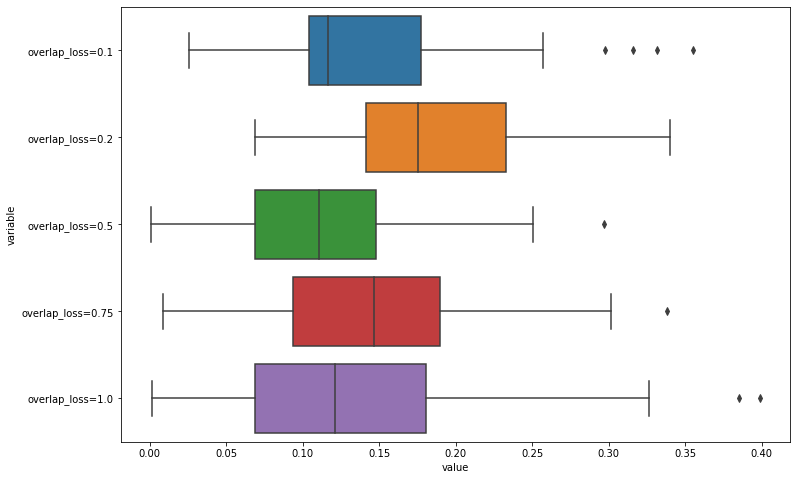

In [37]:
plt.figure(figsize=(12,8))
ari_df = pd.DataFrame(ari_dict).melt()
sns.boxplot(data=ari_df, x="value", y="variable")
#plt.xlim(0,1)
plt.savefig("deepof_variable_warmup.svg")
plt.show()